In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 12.8 MB/s 
     |████████████████████████████████| 3.3 MB 33.9 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 895 kB 26.3 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, DistilBertTokenizer, DistilBertModel
import torch
from transformers import DistilBertForSequenceClassification
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_json("/content/drive/MyDrive/Colab Notebooks/MindSet/train.json")
df_train.head()

,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative


In [ ]:
neutral = df_train[df_train.sentiment == 'neutral'] #.iloc[:1500]
lenght_neutral = [len(elem) for elem in neutral.text]  
neutral['lenght_neutral'] = lenght_neutral
neutral_sorted = neutral.sort_values(by=['lenght_neutral']).iloc[:1500]
neutral_sorted.drop(columns=['id', 'lenght_neutral'], inplace=True)

positive = df_train[df_train.sentiment == 'positive'] #.iloc[:1500]
lenght_positive = [len(elem) for elem in positive.text]  
positive['lenght_positive'] = lenght_positive
positive_sorted = positive.sort_values(by=['lenght_positive']).iloc[:1500]
positive_sorted.drop(columns=['id', 'lenght_positive'], inplace=True)

negative = df_train[df_train.sentiment == 'negative']
negative.drop(columns=['id'], inplace=True)

data = pd.concat([neutral_sorted, positive_sorted, negative], ignore_index=True)
data.sentiment.replace('neutral', 0, inplace=True)
data.sentiment.replace('positive', 1, inplace=True)
data.sentiment.replace('negative', 2, inplace=True)

In [ ]:
df_train = data
text = []
for t in df_train.text:
    text.append(t.replace('\n', ''))
df_train.text = text
df_train.sample(5)

,text,sentiment
2392,Спецрейс для трёхлетнего Ансара из Астаны нача...,1
842,АСТАНА. Кемелбек Ойшибаев ушел с поста председ...,0
2480,«Российские железные дороги» (РЖД) запустили в...,1
964,БАКУ /Trend/ - Новым председателем Союза юриди...,0
318,Глава правительства Бакытжан Сагинтаев провел ...,0


In [ ]:
class_names = ['negative', 'positive', 'neutral']

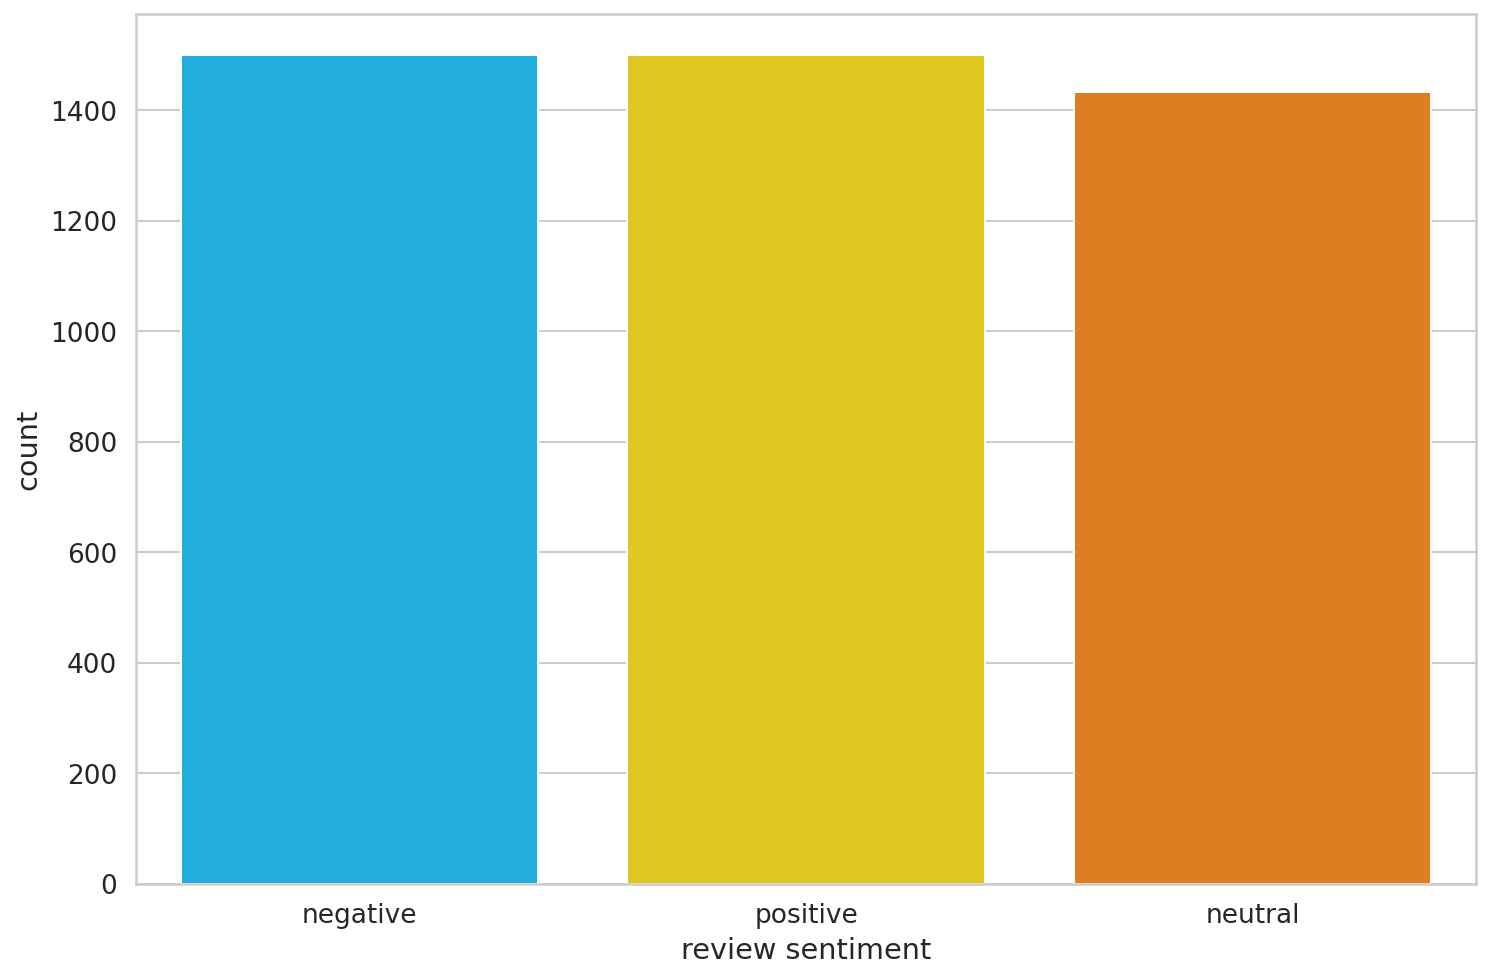

In [ ]:
ax = sns.countplot(df_train.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
# PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/distilrubert-tiny-cased-conversational'

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
MAX_LEN = 512

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
#         with torch.no_grad():
        pooled_output = torch.mean(self.bert(
                                     input_ids=input_ids,
                                     attention_mask=attention_mask
                                     )['last_hidden_state'], dim=1)

        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
#         print(1)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        # print(outputs)
#         print(outputs.shape)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                            input_ids=input_ids,
                            attention_mask=attention_mask
                            )
            
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
best_loss = 10

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss}, accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_test))

    print(f'Val   loss {val_loss}, accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy and val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
        best_loss = val_loss

Epoch 1/3
----------
Train loss 0.7146371307373047, accuracy 0.6528822055137845
Val   loss 0.5886877243007932, accuracy 0.7117117117117117

Epoch 2/3
----------
Train loss 0.473861066699028, accuracy 0.8025062656641604
Val   loss 0.5895845166274479, accuracy 0.7477477477477478

Epoch 3/3
----------
Train loss 0.36545381125807763, accuracy 0.849624060150376
Val   loss 0.6168468445539474, accuracy 0.7342342342342342

CPU times: user 6min 48s, sys: 3.33 s, total: 6min 51s
Wall time: 7min 7s


In [ ]:
history['train_loss']

[0.7146371307373047, 0.473861066699028, 0.36545381125807763]

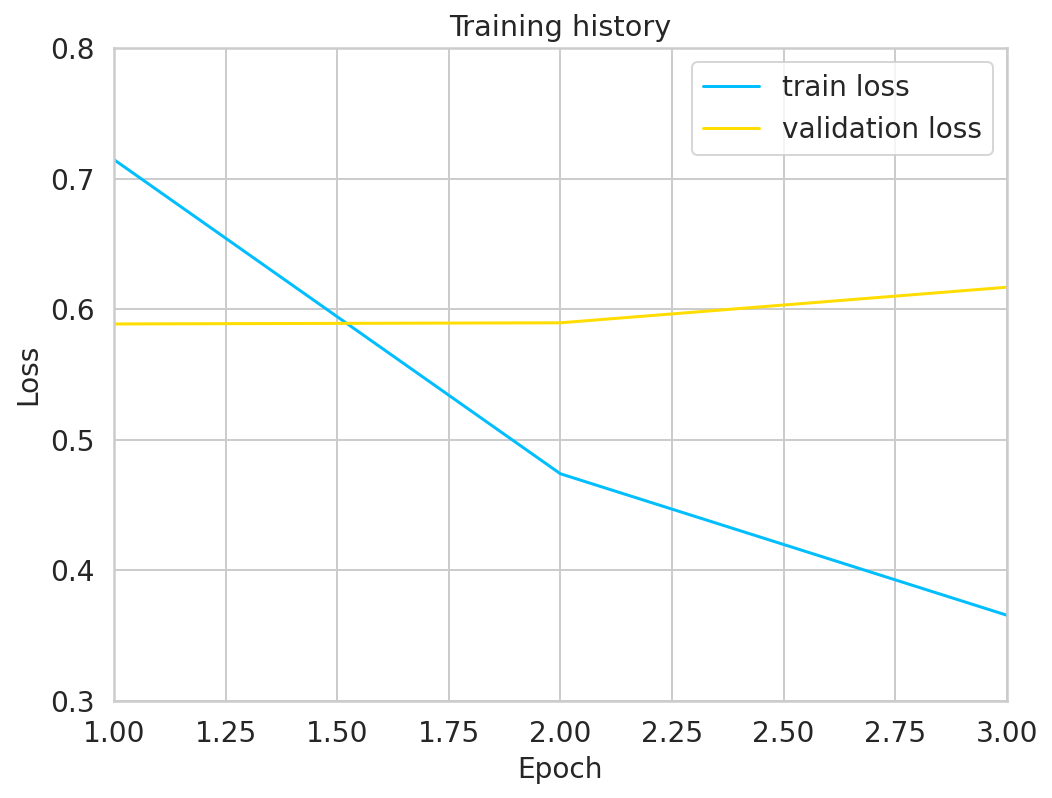

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1,4), history['train_loss'], label='train loss')
plt.plot(range(1,4), history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim([0.3, 0.8]);
plt.xlim([1,3]);

In [ ]:
for i, elem in enumerate(history['train_acc']):
    history['train_acc'][i] = elem.cpu().numpy()
for i, elem in enumerate(history['val_acc']):
    history['val_acc'][i] = elem.cpu().numpy()

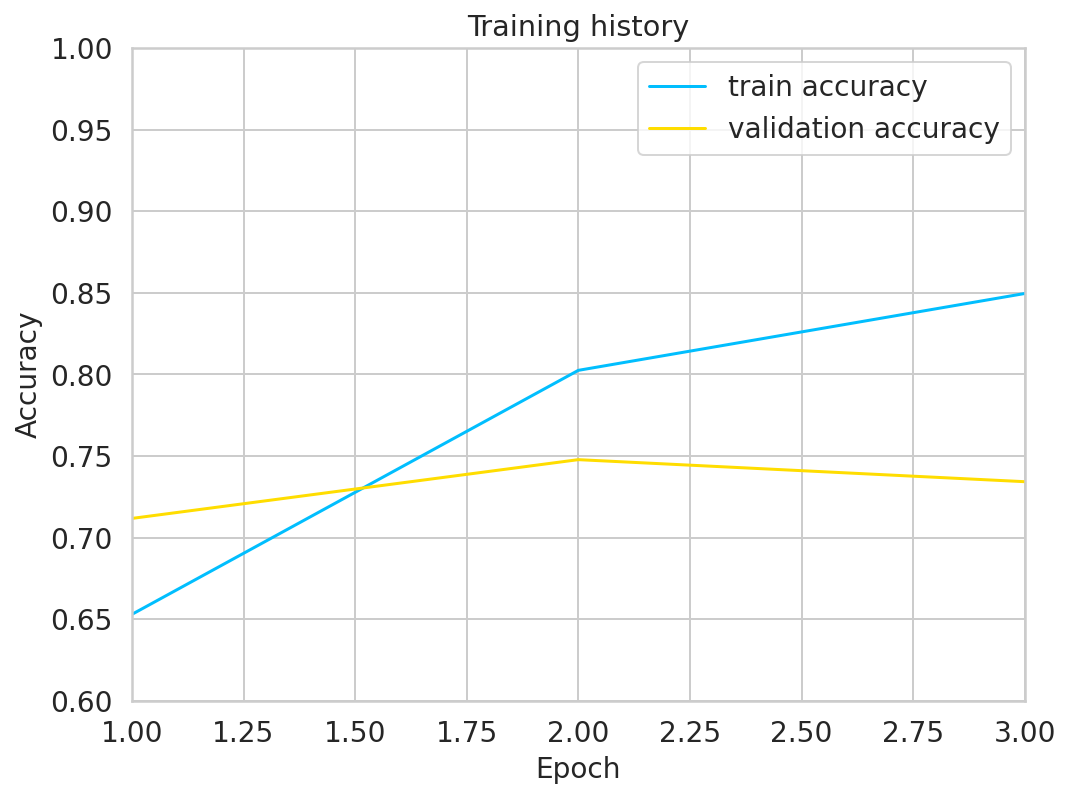

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1,4), history['train_acc'], label='train accuracy')
plt.plot(range(1,4), history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim([0.6, 1]);
plt.xlim([1,3]);

**Best Model**

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Evaluation**

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

print('Test accuracy: {}'.format(test_acc.item()))
# print('Test loss: {}'.format(test_loss.item()))

Test accuracy: 0.7477477477477478


Качество на тестовом наборе данных повысилось, модель хорошо обощает

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.72      0.64      0.67        85
    positive       0.70      0.83      0.76        75
     neutral       0.86      0.81      0.83        62

    accuracy                           0.75       222
   macro avg       0.76      0.76      0.75       222
weighted avg       0.75      0.75      0.75       222



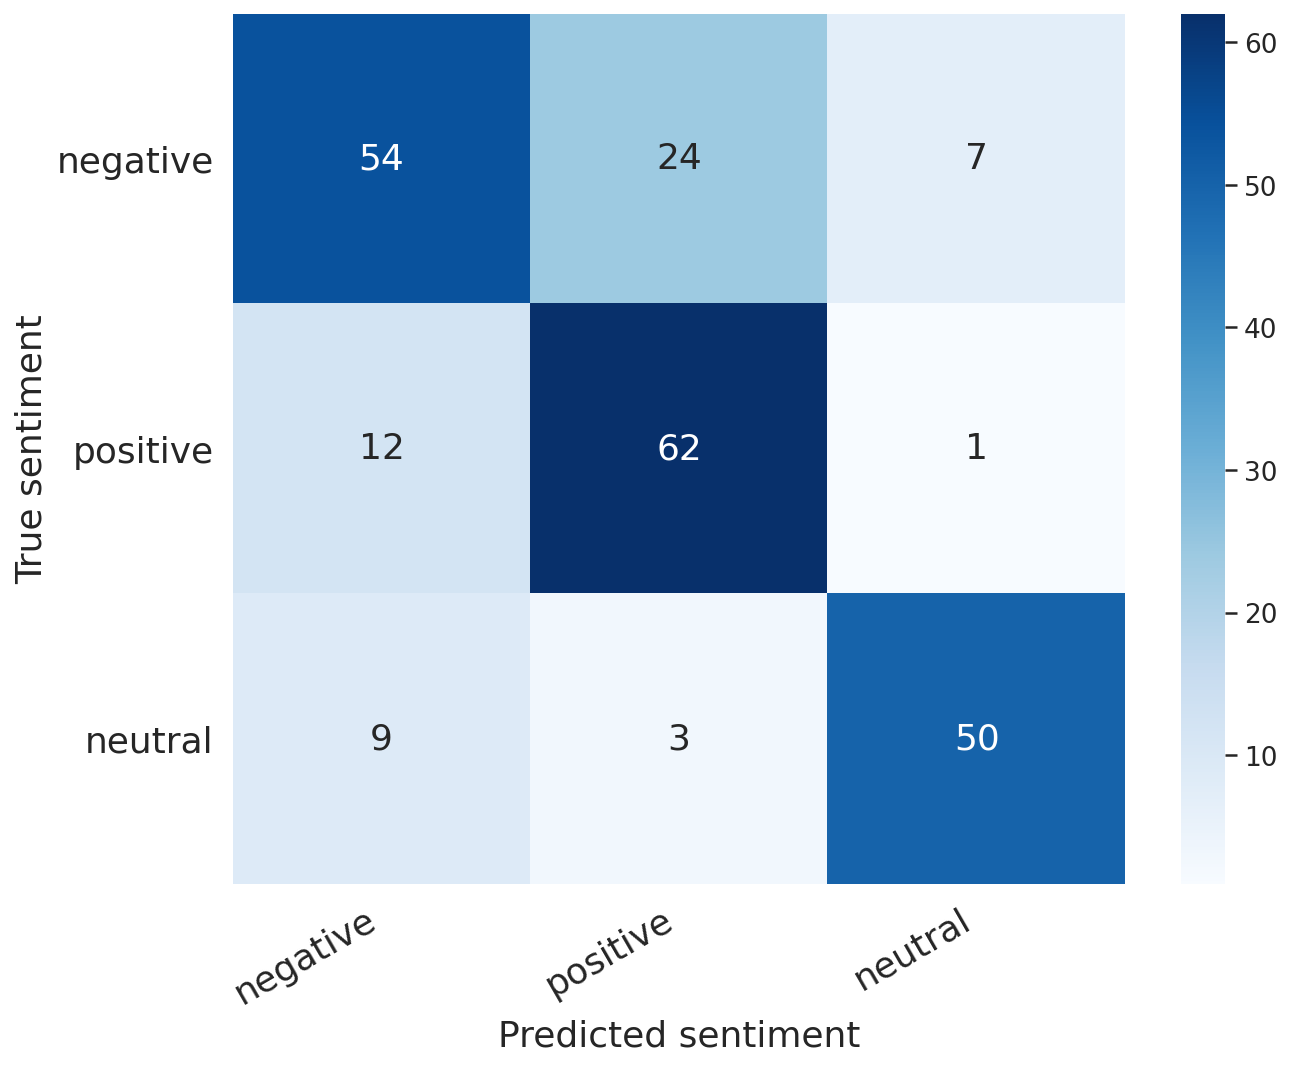

In [ ]:
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True sentiment')
#     plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
# show_confusion_matrix(df_cm)
plt.figure(figsize=(10,8))
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":18})
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True sentiment', fontsize=18)
plt.xlabel('Predicted sentiment', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)

**Пример конкретного текста из тестового набора**

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_sentiment = y_pred[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
pred_df

,class_names,values
0,negative,0.079281
1,positive,0.918561
2,neutral,0.002157


In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')
print(f'Prediction sentiment: {class_names[pred_sentiment]}')

АЛМАТЫ. КАЗИНФОРМ - В Алматы приехал Легендарный цирк Юрия Никулина.
Неповторимый праздник смеха и веселья проходит в алматинском цирке
совместно с  благотворительной акцией «Подари детям жизнь», передает
корреспондент МИА «Казинформ».С каждого купленного билета будет
перечислено 100 тенге на счет общественного Фонда «Добровольное
Общество Милосердие», который на протяжении 10 лет занимается сбором
средств на лечение детей, страдающих от тяжелых заболеваний.
Гастроли цирка  проходят в Алматы ежегодно, начиная с 2013 года,
всегда собирая многочисленную публику и восторженные отзывы. Участники
программы - лауреаты и призеры международных фестивалей в Париже,
Монте-Карло, Будапеште, Лиссабоне, Мадриде, Женеве, Амстердаме. Это
созвездие талантливых артистов, составляющих элиту российского
цирка.Представление имеет насыщенную программу с уникальными номерами,
в число которых входят Воздушные полотна, Колесо Сира, «Канатоходцы» и
«Перши», дрессированные морские котики и медведи.      К слову

Уверенность модели:

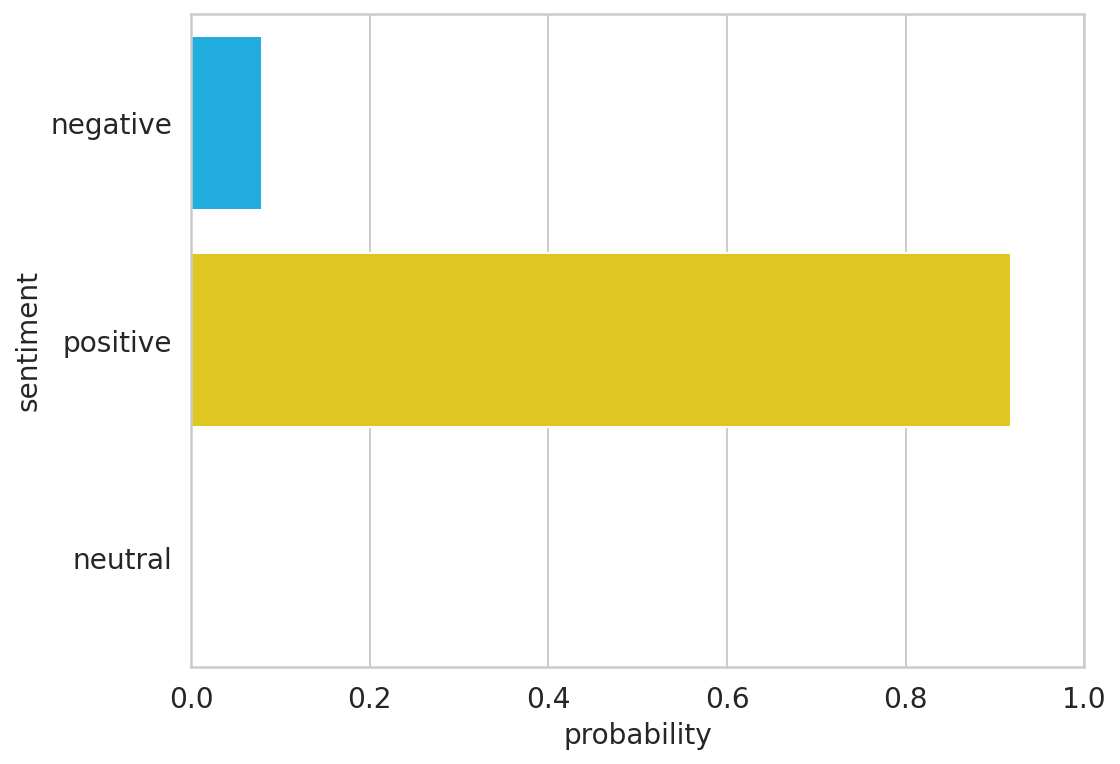

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment', fontsize=14)
plt.xlabel('probability', fontsize=14)
plt.xlim([0, 1]);
plt.tick_params(axis='both', which='major', labelsize=14)

Predicting on Raw Text

In [ ]:
review_text = "Какая отвратительная погода сегодня!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Какая отвратительная погода сегодня!!!
Sentiment  : negative
